In [34]:
import open3d as o3d
import pyrealsense2 as rs
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import itertools

In [44]:
def acquire(n_frames):
    nframes = n_frames

    # Camera RIGHT
    pipeline = rs.pipeline()
    config = rs.config()
    config.enable_device('233722072412')
    pipeline_wrapper = rs.pipeline_wrapper(pipeline)
    pipeline_profile = config.resolve(pipeline_wrapper)
    device = pipeline_profile.get_device()
    advnc_mode = rs.rs400_advanced_mode(device)
    current_std_depth_table = advnc_mode.get_depth_table()
    current_std_depth_table.depthClampMin = 0
    current_std_depth_table.depthClampMax = 800
    advnc_mode.set_depth_table(current_std_depth_table)
    config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
    config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)

    # Camera LEFT
    pipeline_2 = rs.pipeline()
    config_2 = rs.config()
    config_2.enable_device('032622070359')
    pipeline_wrapper_2 = rs.pipeline_wrapper(pipeline_2)
    pipeline_profile_2 = config_2.resolve(pipeline_wrapper_2)
    device_2 = pipeline_profile_2.get_device()
    advnc_mode_2 = rs.rs400_advanced_mode(device_2)
    current_std_depth_table_2 = advnc_mode_2.get_depth_table()
    current_std_depth_table_2.depthClampMin = 0
    current_std_depth_table_2.depthClampMax = 800
    advnc_mode_2.set_depth_table(current_std_depth_table_2)
    config_2.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
    config_2.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)


    align = rs.align(rs.stream.depth)
    cfg = pipeline.start(config)
    profile = cfg.get_stream(rs.stream.depth)
    intr_right = profile.as_video_stream_profile().get_intrinsics()

    cfg_2 = pipeline_2.start(config_2)
    profile_2 = cfg_2.get_stream(rs.stream.depth)
    intr_left = profile_2.as_video_stream_profile().get_intrinsics()

    depths_left = []
    depths_right = []
    cnt = 0
    print("Acquisizione iniziata")
    while cnt<=90+nframes:
        # RIGHT
        frames = pipeline.wait_for_frames()
        frames = align.process(frames)
        depth_frame = frames.get_depth_frame()
        depth_image = np.asarray(depth_frame.get_data())
        if cnt>90:
            depths_right.append(depth_image)
        color_frame = frames.get_color_frame()
        color_image = np.asarray(color_frame.get_data())

        #LEFT
        frames_2 = pipeline_2.wait_for_frames()
        frames_2 = align.process(frames_2)
        depth_frame_2 =frames_2.get_depth_frame()
        depth_image_2 = np.asarray(depth_frame_2.get_data())
        if cnt>=90:
            depths_left.append(depth_image_2)
        color_frame_2 = frames_2.get_color_frame()
        color_image_2 = np.asarray(color_frame_2.get_data())

        cnt += 1

    pipeline.stop()
    pipeline_2.stop()
    print("Acquisizione finita")
    variances_left = np.zeros((720, 1280))
    means_left = np.zeros((720, 1280))
    inliers_left = np.zeros((720, 1280))
    variances_right = np.zeros((720, 1280))
    means_right = np.zeros((720, 1280))
    inliers_right = np.zeros((720, 1280))
    for i in range(0, 720):
        for j in range(0, 1280):
            support_left = []
            support_right = []
            for k in range(0, nframes):
                if depths_left[k][i][j] > 0:
                    support_left.append(depths_left[k][i][j])
                if depths_right[k][i][j] > 0:
                    support_right.append(depths_right[k][i][j])
            if len(support_left) > 0:
                inliers_left[i,j] = len(support_left)
                variances_left[i,j] = np.var(support_left)
                means_left [i,j] = np.mean(support_left)
            else:
                variances_left[i,j] = -1
            if len(support_right) > 0:
                inliers_right[i,j] = len(support_right)
                variances_right[i,j] = np.var(support_right)
                means_right [i,j] = np.mean(support_right)
            else:
                variances_right[i,j] = -1
    return depths_left, variances_left, means_left, inliers_left, color_image_2, depths_right, variances_right, means_right, inliers_right, color_image, intr_left, intr_right

In [45]:
# LEFT
def get_maps(variances, means, threshold=None):
    max_value = variances.max()
    invalid_indexes = np.argwhere(variances==-1)
    valid_variances = np.copy(variances)
    valid_variances[invalid_indexes[:,0], invalid_indexes[:,1]] = max_value
    if threshold is None:
        threshold = np.median(variances[variances!=-1])
    print(f'Threshold: {threshold}')

    from scipy.interpolate import interp1d

    img_indexes = np.argwhere(valid_variances<threshold)
    high_variance_indexes = np.argwhere(valid_variances>=threshold)

    
    filtered_means = np.copy(means)
    filtered_means[high_variance_indexes[:,0], high_variance_indexes[:,1]] = 0
    zero_variance_indexes = np.argwhere(valid_variances==0)
    zero_variance_image = np.zeros((720, 1280))
    zero_variance_image[zero_variance_indexes[:,0], zero_variance_indexes[:,1]] = 255

    variance_image = np.zeros((720, 1280))
    m = interp1d([valid_variances.min(),threshold],[0,254])
    variance_image[img_indexes[:,0], img_indexes[:,1]] =  m(valid_variances[img_indexes[:,0], img_indexes[:,1]])

    variance_image[high_variance_indexes[:,0], high_variance_indexes[:,1]] = 255

    return variance_image, zero_variance_image, threshold, filtered_means

In [46]:
d_l, v_l, m_l, in_l, col_l, d_r, v_r, m_r, in_r, col_r, intr_left, intr_right = acquire(90)

Acquisizione iniziata
Acquisizione finita


In [49]:
variance_image_l, zero_variance_image_l, threshold_l, filtered_means_l = get_maps(v_l, m_l, 1)
variance_image_r, zero_variance_image_r, threshold_r, filtered_means_r = get_maps(v_r, m_r, 1)

Threshold: 1
Threshold: 1


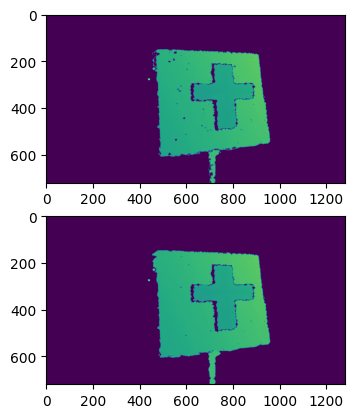

In [50]:
plt.subplot(2,1,1)
plt.imshow(filtered_means_l)
plt.subplot(2,1,2)
plt.imshow(m_l)
plt.show()

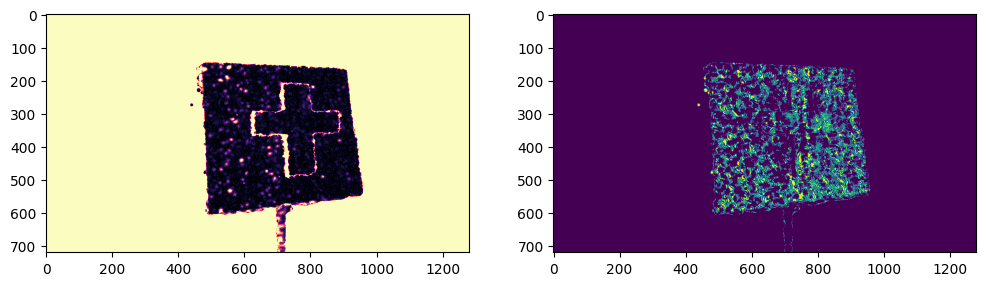

LEFT IMAGE: variance map with max value: 1 mm
RIGHT IMAGE: Zero variance map


In [51]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(variance_image_l, cmap="magma")
cv2.imwrite("varianza zero.png", variance_image_l)
plt.subplot(1,2,2)
plt.imshow(zero_variance_image_l)
plt.show()
print(f'LEFT IMAGE: variance map with max value: {threshold_l} mm\nRIGHT IMAGE: Zero variance map')

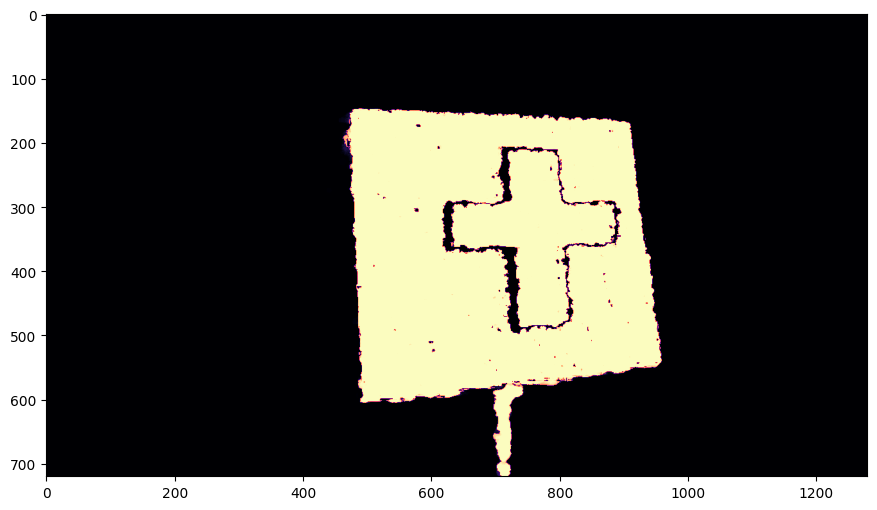

In [52]:
# Inliers map
from scipy.interpolate import interp1d

m = interp1d([in_l.min(),in_l.max()],[0,255])
inliers_map = m(in_l)
plt.figure(figsize=(12,6))
plt.imshow(inliers_map, cmap="magma")
plt.show()

In [53]:
valid = v_l[v_l>-1]
hist_variance, aa = np.histogram(valid[valid < threshold_l], bins=100)

In [54]:
hist_variance, aa

(array([46301, 13359, 14282, 11173, 10320,  9056,  8155,  7462,  6763,
        10813,  5083,  4873,  4609,  6662,  3314,  2937,  4841,  3472,
         1001,   956,   922,   810,   964,   718,   720,   710,   544,
          529,   411,   383,   339,   387,   286,   351,   273,   255,
          372,   187,   208,   214,   144,   219,   194,   144,   225,
          109,   120,   168,   127,   158,    85,   117,   151,    78,
          157,    96,   109,    99,    92,   114,    71,   106,    70,
           68,    86,    70,   101,    48,    86,    59,    51,    53,
           68,    49,    32,    51,    47,    46,    53,    48,    57,
           51,    61,    22,    40,    25,    24,    43,    67,    60,
           20,    49,    18,    51,    17,    28,    56,    22,    41,
           18], dtype=int64),
 array([0.        , 0.00999871, 0.01999742, 0.02999613, 0.03999483,
        0.04999354, 0.05999225, 0.06999096, 0.07998967, 0.08998838,
        0.09998709, 0.1099858 , 0.1199845 , 0.1299832

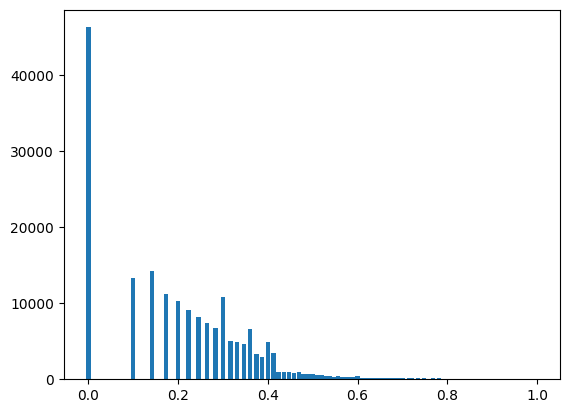

In [55]:
plt.bar(np.sqrt(aa[:-1]), hist_variance, width=threshold_l/100)  # arguments are passed to np.histogram

plt.show()

In [56]:
indexes = np.argwhere(variance_image_l == 255)
selected_m_l = np.copy(m_l)
selected_m_l[indexes[:,0], indexes[:,1]] = 0
cv2.imwrite("leftDepth.png", np.uint16(selected_m_l))
cv2.imwrite("leftColor.jpg", col_l)

indexes = np.argwhere(variance_image_r == 255)
selected_m_r = np.copy(m_r)
selected_m_r[indexes[:,0], indexes[:,1]] = 0
cv2.imwrite("rightDepth.png", np.uint16(selected_m_r))
cv2.imwrite("rightColor.jpg", col_r)


depth_raw_left = o3d.io.read_image("leftDepth.png")
color_raw_left = o3d.io.read_image("leftColor.jpg")
depth_raw_right = o3d.io.read_image("rightDepth.png")
color_raw_right = o3d.io.read_image("rightColor.jpg")
rgbd_image_left = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_left, depth_raw_left)
rgbd_image_right = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_right, depth_raw_right)

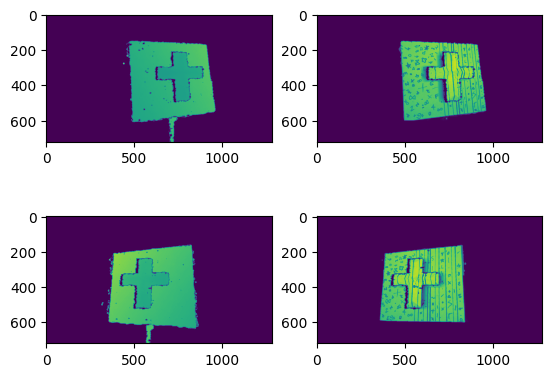

In [57]:
plt.subplot(2,2,1)
plt.imshow(rgbd_image_left.depth)
plt.subplot(2,2,2)
plt.imshow(rgbd_image_left.color)
plt.subplot(2,2,3)
plt.imshow(rgbd_image_right.depth)
plt.subplot(2,2,4)
plt.imshow(rgbd_image_right.color)
plt.show()

In [58]:
import copy

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    #target_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[1.0, 0.0, 0.0],
                                      lookat=[1, 0, 0],
                                      up=[-0., 1, -0.0])

In [59]:
camera_intrinsic_left = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr_left.width, intr_left.height, intr_left.fx, intr_left.fy, intr_left.ppx, intr_left.ppy
))
camera_intrinsic_right = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr_right.width, intr_right.height, intr_right.fx, intr_right.fy, intr_right.ppx, intr_right.ppy
))

In [60]:
pcd_left = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_left, camera_intrinsic_left)
pcd_right = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_right, camera_intrinsic_right)

bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.1, 0.7]]  # set the bounds
bounding_box_points = list(itertools.product(*bounds))  # create limit points
bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object

# Crop the point cloud using the bounding box:
pcd_left = pcd_left.crop(bounding_box)
pcd_right = pcd_right.crop(bounding_box)

# Rotazione di 180° intorno all'asse X (ribaltare la point cloud poiché la pinhole camera ribalta la visuale)
angolo = np.pi
trans_x = np.asarray([   [1.0, 0.0, 0.0, 0.0],
                         [0.0, np.cos(angolo), -np.sin(angolo), 0.0],
                         [0.0, np.sin(angolo), np.cos(angolo), 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

pcd_left.transform(trans_x)
pcd_right.transform(trans_x)

# Primario -> Camera di destra 
# Secondario -> Camera di sinistra

# Rotazione di -30° intorno all'asse Y
angolo = np.pi/6
trans_y = np.asarray([[np.cos(angolo), 0.0, np.sin(angolo), -0.34],
                         [0.0, 1.0, 0.0, 0.0],
                         [-np.sin(angolo), 0.0, np.cos(angolo), 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

#pcd_left.transform(trans_y)

#pcd_left.paint_uniform_color((1,0,0))  # LEFT BLU

#pcd_right.paint_uniform_color((0,0,1)) # RIGHT ROSSO

#o3d.visualization.draw_geometries([pcd_left, pcd_right])

In [61]:
angolo = np.pi/6
source = pcd_left
target = pcd_right
threshold = 0.01
trans_init = np.asarray([[np.cos(angolo), 0.0, -np.sin(angolo), -0.31],
                         [0.0, 1.0, 0.0, 0.0],
                         [np.sin(angolo), 0.0, np.cos(angolo), -0.1],
                         [0.0, 0.0, 0.0, 1.0]])
draw_registration_result(source, target, trans_init)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: L'operazione di trasformazione richiesta non è supportata. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Handle non valido. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Handle non valido. 


In [62]:
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, trans_init)
print(evaluation)

Initial alignment
RegistrationResult with fitness=6.271330e-01, inlier_rmse=5.553063e-03, and correspondence_set size of 119001
Access transformation to get result.


In [63]:
print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=10000))
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(source, target, reg_p2p.transformation)


Apply point-to-point ICP
RegistrationResult with fitness=9.372925e-01, inlier_rmse=1.833578e-03, and correspondence_set size of 177855
Access transformation to get result.
Transformation is:
[[ 0.87744087  0.00286398 -0.47967627 -0.32019943]
 [ 0.02713921  0.99808404  0.05560321  0.00203671]
 [ 0.47891648 -0.06180656  0.875682   -0.09111317]
 [ 0.          0.          0.          1.        ]]


In [64]:
calibrated_matrix = reg_p2p.transformation

In [65]:
calibrated_matrix

array([[ 0.87744087,  0.00286398, -0.47967627, -0.32019943],
       [ 0.02713921,  0.99808404,  0.05560321,  0.00203671],
       [ 0.47891648, -0.06180656,  0.875682  , -0.09111317],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [119]:
pcd_left = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_left, camera_intrinsic_left)
pcd_right = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_right, camera_intrinsic_right)

bounds = [[-math.inf, math.inf], [-math.inf, 0.15], [0.1, 1.0]]  # set the bounds
bounding_box_points = list(itertools.product(*bounds))  # create limit points
bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object

# Crop the point cloud using the bounding box:
pcd_left = pcd_left.crop(bounding_box)
pcd_right = pcd_right.crop(bounding_box)

# Rotazione di 180° intorno all'asse X (ribaltare la point cloud poiché la pinhole camera ribalta la visuale)
angolo = np.pi
trans_x = np.asarray([   [1.0, 0.0, 0.0, 0.0],
                         [0.0, np.cos(angolo), -np.sin(angolo), 0.0],
                         [0.0, np.sin(angolo), np.cos(angolo), 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

pcd_left.transform(trans_x)
pcd_right.transform(trans_x)


pcd_left.transform(calibrated_matrix)

pcd_left.paint_uniform_color((1,0,0))  # LEFT BLU

pcd_right.paint_uniform_color((0,0,1)) # RIGHT ROSSO

o3d.visualization.draw_geometries([pcd_left, pcd_right])

In [79]:
test = pcd_left.transform(reg_p2p.transformation)
p1_load = np.asarray(test.points)
p1_color = np.asarray(test.colors)
p2_load = np.asarray(pcd_right.points)
p2_color = np.asarray(pcd_right.colors)

p3_load = np.concatenate((p1_load, p2_load), axis=0)
p3_color = np.concatenate((p1_color, p2_color), axis=0)

new_pcd = o3d.geometry.PointCloud()
new_pcd.points = o3d.utility.Vector3dVector(p3_load)
new_pcd.colors = o3d.utility.Vector3dVector(p3_color)

In [165]:
o3d.visualization.draw_geometries([new_pcd])

# ACQUISIZIONE

In [77]:
def one_shot():
    # Camera RIGHT
    pipeline = rs.pipeline()
    config = rs.config()
    config.enable_device('233722072412')
    pipeline_wrapper = rs.pipeline_wrapper(pipeline)
    pipeline_profile = config.resolve(pipeline_wrapper)
    device = pipeline_profile.get_device()
    advnc_mode = rs.rs400_advanced_mode(device)
    current_std_depth_table = advnc_mode.get_depth_table()
    current_std_depth_table.depthClampMin = 0
    current_std_depth_table.depthClampMax = 800
    advnc_mode.set_depth_table(current_std_depth_table)
    config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
    config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)

    # Camera LEFT
    pipeline_2 = rs.pipeline()
    config_2 = rs.config()
    config_2.enable_device('032622070359')
    pipeline_wrapper_2 = rs.pipeline_wrapper(pipeline_2)
    pipeline_profile_2 = config_2.resolve(pipeline_wrapper_2)
    device_2 = pipeline_profile_2.get_device()
    advnc_mode_2 = rs.rs400_advanced_mode(device_2)
    current_std_depth_table_2 = advnc_mode_2.get_depth_table()
    current_std_depth_table_2.depthClampMin = 0
    current_std_depth_table_2.depthClampMax = 800
    advnc_mode_2.set_depth_table(current_std_depth_table_2)
    config_2.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
    config_2.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)


    align = rs.align(rs.stream.depth)
    cfg = pipeline.start(config)
    profile = cfg.get_stream(rs.stream.depth)
    intr_right = profile.as_video_stream_profile().get_intrinsics()

    cfg_2 = pipeline_2.start(config_2)
    profile_2 = cfg_2.get_stream(rs.stream.depth)
    intr_left = profile_2.as_video_stream_profile().get_intrinsics()

    cnt = 0
    print("Acquisizione iniziata")
    while cnt<=90:
        cnt += 1
        frames = pipeline.wait_for_frames()
        frames = align.process(frames)
        frames_2 = pipeline_2.wait_for_frames()
        frames_2 = align.process(frames_2)
    print("\n\n----  CHEESE :-)  ---- \n\n")
    # RIGHT
    frames = pipeline.wait_for_frames()
    frames = align.process(frames)
    depth_frame = frames.get_depth_frame()
    depth_image = np.asarray(depth_frame.get_data())
    color_frame = frames.get_color_frame()
    color_image = np.asarray(color_frame.get_data())

    #LEFT
    frames_2 = pipeline_2.wait_for_frames()
    frames_2 = align.process(frames_2)
    depth_frame_2 =frames_2.get_depth_frame()
    depth_image_2 = np.asarray(depth_frame_2.get_data())
    color_frame_2 = frames_2.get_color_frame()
    color_image_2 = np.asarray(color_frame_2.get_data())
    pipeline.stop()
    pipeline_2.stop()


    print("Acquisizione finita")
    
    return depth_image_2, color_image_2, intr_left, depth_image, color_image, intr_right

def save_pcl(number, pointcloud1, pointcloud2):
    p1_colors = pointcloud1.colors
    p2_colors = pointcloud2.colors
    p1_load = pointcloud1.points
    p2_load = pointcloud2.points
    p3_colors = np.concatenate((p1_colors, p2_colors), axis=0)
    p3_load = np.concatenate((p1_load, p2_load), axis=0)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(p3_load)
    #pcd.colors = o3d.utility.Vector3dVector(p3_colors)
    o3d.io.write_point_cloud(f'./acquisizioni/noncalibrato/{number}.pcd', pcd, write_ascii=False, compressed=False, print_progress=False)
    return True

In [78]:
matrice_calibrazione = np.asarray([[ 0.87744087,  0.00286398, -0.47967627, -0.32019943],
       [ 0.02713921,  0.99808404,  0.05560321,  0.00203671],
       [ 0.47891648, -0.06180656,  0.875682  , -0.09111317],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

for i in range(1,20):
    depth_image_l, color_image_l, intr_left, depth_image_r, color_image_r, intr_right = one_shot()
    cv2.imwrite("leftDepth.png", depth_image_l)
    cv2.imwrite("leftColor.jpg", color_image_l)

    cv2.imwrite("rightDepth.png", depth_image_r)
    cv2.imwrite("rightColor.jpg", color_image_r)

    depth_raw_left = o3d.io.read_image("leftDepth.png")
    color_raw_left = o3d.io.read_image("leftColor.jpg")
    depth_raw_right = o3d.io.read_image("rightDepth.png")
    color_raw_right = o3d.io.read_image("rightColor.jpg")
    rgbd_image_left = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_left, depth_raw_left)
    rgbd_image_right = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_right, depth_raw_right)
    plt.subplot(2,2,1)
    plt.imshow(rgbd_image_left.depth)
    plt.subplot(2,2,2)
    plt.imshow(rgbd_image_left.color)
    plt.subplot(2,2,3)
    plt.imshow(rgbd_image_right.depth)
    plt.subplot(2,2,4)
    plt.imshow(rgbd_image_right.color)

    camera_intrinsic_left = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
        intr_left.width, intr_left.height, intr_left.fx, intr_left.fy, intr_left.ppx, intr_left.ppy
    ))
    camera_intrinsic_right = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
        intr_right.width, intr_right.height, intr_right.fx, intr_right.fy, intr_right.ppx, intr_right.ppy
    ))

    pcd_left = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_left, camera_intrinsic_left)
    pcd_right = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_right, camera_intrinsic_right)

    bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.1, 0.7]]  # set the bounds
    bounding_box_points = list(itertools.product(*bounds))  # create limit points
    bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object

    # Crop the point cloud using the bounding box:
    pcd_left = pcd_left.crop(bounding_box)
    pcd_right = pcd_right.crop(bounding_box)

    # Rotazione di 180° intorno all'asse X (ribaltare la point cloud poiché la pinhole camera ribalta la visuale)
    angolo = np.pi
    trans_x = np.asarray([   [1.0, 0.0, 0.0, 0.0],
                            [0.0, np.cos(angolo), -np.sin(angolo), 0.0],
                            [0.0, np.sin(angolo), np.cos(angolo), 0.0],
                            [0.0, 0.0, 0.0, 1.0]])

    pcd_left.transform(trans_x)
    pcd_right.transform(trans_x)

    pcd_left.transform(matrice_calibrazione)

    #pcd_left.paint_uniform_color((1,0,0))  # LEFT BLU

    #pcd_right.paint_uniform_color((0,0,1)) # RIGHT ROSSO

    #o3d.visualization.draw_geometries([pcd_left, pcd_right])
    print("pointcloud ",i)
    save_pcl(i, pcd_left, pcd_right)


Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  1
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  2
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  3
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  4
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  5
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  6
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  7
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  8
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  9
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  10
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  11
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
poin

In [79]:
matrice_calibrazione = np.asarray([[ 0.8444589 , -0.01225705, -0.5354801 , -0.31844794],
       [ 0.02003144,  0.99976145,  0.00870546,  0.00107881],
       [ 0.53524566, -0.01807784,  0.84450298, -0.09396772],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

for i in range(1,20):
    depth_image_l, color_image_l, intr_left, depth_image_r, color_image_r, intr_right = one_shot()
    cv2.imwrite("leftDepth.png", depth_image_l)
    cv2.imwrite("leftColor.jpg", color_image_l)

    cv2.imwrite("rightDepth.png", depth_image_r)
    cv2.imwrite("rightColor.jpg", color_image_r)

    depth_raw_left = o3d.io.read_image("leftDepth.png")
    color_raw_left = o3d.io.read_image("leftColor.jpg")
    depth_raw_right = o3d.io.read_image("rightDepth.png")
    color_raw_right = o3d.io.read_image("rightColor.jpg")
    rgbd_image_left = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_left, depth_raw_left)
    rgbd_image_right = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_right, depth_raw_right)
    plt.subplot(2,2,1)
    plt.imshow(rgbd_image_left.depth)
    plt.subplot(2,2,2)
    plt.imshow(rgbd_image_left.color)
    plt.subplot(2,2,3)
    plt.imshow(rgbd_image_right.depth)
    plt.subplot(2,2,4)
    plt.imshow(rgbd_image_right.color)

    camera_intrinsic_left = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
        intr_left.width, intr_left.height, intr_left.fx, intr_left.fy, intr_left.ppx, intr_left.ppy
    ))
    camera_intrinsic_right = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
        intr_right.width, intr_right.height, intr_right.fx, intr_right.fy, intr_right.ppx, intr_right.ppy
    ))

    pcd_left = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_left, camera_intrinsic_left)
    pcd_right = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_right, camera_intrinsic_right)

    bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.1, 0.7]]  # set the bounds
    bounding_box_points = list(itertools.product(*bounds))  # create limit points
    bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object

    # Crop the point cloud using the bounding box:
    pcd_left = pcd_left.crop(bounding_box)
    pcd_right = pcd_right.crop(bounding_box)

    # Rotazione di 180° intorno all'asse X (ribaltare la point cloud poiché la pinhole camera ribalta la visuale)
    angolo = np.pi
    trans_x = np.asarray([   [1.0, 0.0, 0.0, 0.0],
                            [0.0, np.cos(angolo), -np.sin(angolo), 0.0],
                            [0.0, np.sin(angolo), np.cos(angolo), 0.0],
                            [0.0, 0.0, 0.0, 1.0]])

    pcd_left.transform(trans_x)
    pcd_right.transform(trans_x)

    angolo = np.pi/6
    source = pcd_left
    target = pcd_right
    threshold = 0.01
    trans_init = np.asarray([[np.cos(angolo), 0.0, -np.sin(angolo), -0.31],
                            [0.0, 1.0, 0.0, 0.0],
                            [np.sin(angolo), 0.0, np.cos(angolo), -0.1],
                            [0.0, 0.0, 0.0, 1.0]])
    #draw_registration_result(source, target, trans_init)
    
    print("Apply point-to-point ICP")
    reg_p2p = o3d.pipelines.registration.registration_icp(
        source, target, threshold, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=10000))
    #print(reg_p2p)
    print(f"Transformation {i} is:")
    print(reg_p2p.transformation)
    pcd_left.transform(reg_p2p.transformation)
    save_pcl(i, pcd_left, pcd_right)

Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
Apply point-to-point ICP
Transformation 1 is:
[[ 0.96439719  0.00498677 -0.26441103 -0.22731136]
 [ 0.0113009   0.99813182  0.06004295  0.00325073]
 [ 0.26421648 -0.06089333  0.96253917 -0.03977853]
 [ 0.          0.          0.          1.        ]]
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
Apply point-to-point ICP
Transformation 2 is:
[[ 0.96640683  0.0034855  -0.25699354 -0.22419256]
 [ 0.01266512  0.99804747  0.06116246  0.00383061]
 [ 0.25670494 -0.06236268  0.96447575 -0.03860063]
 [ 0.          0.          0.          1.        ]]
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
Apply point-to-point ICP
Transformation 3 is:
[[ 0.96079963  0.0075421  -0.27714108 -0.2327066 ]
 [ 0.00952365  0.9981421   0.0601802   0.00318053]
 [ 0.27708007 -0.06046051  0.95894273 -0.04199546]
 [ 0.          0.          0.          1.        ]]
Acquisizione iniziata


----  CHEESE 

In [80]:
from scipy.spatial.transform import Rotation   

def get_angles_from_transform_matrix(matrix):
    x = matrix[0][0:3]
    y = matrix[1][0:3]
    z = matrix[2][0:3]
    rotation_matrix = np.array([matrix[0][0:3],matrix[1][0:3],matrix[2][0:3]])
    t = [matrix[0][3], matrix[1][3], matrix[2][3]]
    r =  Rotation.from_matrix(rotation_matrix)
    angles = r.as_euler("xyz",degrees=True)
    #print(f"R_x: {angles[0]:.3f}°  R_y: {angles[1]:.3f}°  R_z: {angles[2]:.3f}°")
    #print(f"T_x: {t[0]:.3f}  T_y: {t[1]:.3f}  T_z: {t[2]:.3f}")
    return angles, t

In [78]:
matrici_non_calibrate = np.asarray([
[[ 0.99307216, -0.10518637, -0.05237862, -0.12894168],
 [ 0.10494697,  0.99445097, -0.00730777, -0.01250373],
 [ 0.05285665,  0.00176017,  0.99860056, -0.00770196],
 [ 0.        ,  0.        ,  0.        ,  1.        ]],
[[ 0.9931595 , -0.11592749, -0.01396542, -0.11397078],
 [ 0.115814  ,  0.99323298, -0.00868138, -0.01420774],
 [ 0.01487733,  0.0070046 ,  0.99986479, -0.00541292],
 [ 0.        ,  0.        ,  0.        ,  1.        ]],
[[ 0.99200023, -0.09834897, -0.07913926, -0.13959892],
 [ 0.09831417,  0.99514594, -0.00434546, -0.01077607],
 [ 0.07918249, -0.00346981,  0.9968541 , -0.00992571],
 [ 0.        ,  0.        ,  0.        ,  1.        ]],
[[ 0.99328377, -0.11524313, -0.01031367, -0.11188411],
 [ 0.11513521,  0.99329422, -0.01051051, -0.01447161],
 [ 0.01145578,  0.00925245,  0.99989157, -0.00527416],
 [ 0.        ,  0.        ,  0.        ,  1.        ]],
[[ 9.93080690e-01, -1.17431022e-01,  8.35811306e-04, -1.07709100e-01],
 [ 1.17433340e-01,  9.93073780e-01, -3.72522369e-03, -1.19532952e-02],
 [-3.92565470e-04,  3.79759982e-03,  9.99992712e-01, -4.81541969e-03],
 [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],
[[ 0.99137581, -0.10269318, -0.08141329, -0.14089403],
 [ 0.10269593,  0.99470408, -0.00416469, -0.0108281 ],
 [ 0.08140982, -0.00423204,  0.99667173, -0.0100954 ],
 [ 0.        ,  0.        ,  0.        ,  1.        ]],
[[ 9.93268912e-01, -1.13791354e-01, -2.16424604e-02, -1.16823999e-01],
 [ 1.13754042e-01,  9.93504558e-01, -2.95136117e-03, -1.09571285e-02],
 [ 2.18377224e-02,  4.69577947e-04,  9.99761418e-01, -6.12911875e-03],
 [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],
[[ 0.99339245, -0.10647924, -0.04282069, -0.12501317],
 [ 0.10633128,  0.99431428, -0.00572474, -0.01176204],
 [ 0.04318679,  0.00113374,  0.99906637, -0.00732765],
 [ 0.        ,  0.        ,  0.        ,  1.        ]],
[[ 0.99200924, -0.10997974, -0.06182327, -0.1325291 ],
 [ 0.10984296,  0.99393308, -0.00561707, -0.01154582],
 [ 0.06206595, -0.00121866,  0.99807131, -0.00889451],
 [ 0.        ,  0.        ,  0.        ,  1.        ]],
[[ 0.99319108, -0.10495737, -0.05055122, -0.12810329],
 [ 0.1049417 ,  0.99447394, -0.00297153, -0.01027187],
 [ 0.05058375, -0.00235363,  0.99871705, -0.00791101],
 [ 0.        ,  0.        ,  0.        ,  1.        ]],
[[ 9.92728075e-01, -9.45013009e-02, -7.45685816e-02, -1.37634517e-01],
 [ 9.41624953e-02,  9.95524262e-01, -8.05413010e-03, -1.28794527e-02],
 [ 7.49959579e-02,  9.73997361e-04,  9.97183362e-01, -9.46940486e-03],
 [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],
[[ 0.9515349 , -0.05987089, -0.30165676, -0.22617782],
 [ 0.05933206,  0.99817816, -0.01095709, -0.01157947],
 [ 0.3017632 , -0.00747187,  0.95335363, -0.03779917],
 [ 0.        ,  0.        ,  0.        ,  1.        ]],
[[ 0.96845933, -0.0729093 , -0.23826617, -0.20206438],
 [ 0.07318298,  0.99728873, -0.00770941, -0.01125467],
 [ 0.23818225, -0.00997078,  0.97116929, -0.02784885],
 [ 0.        ,  0.        ,  0.        ,  1.        ]],
[[ 0.94792258, -0.06797518, -0.3111626 , -0.23059893],
 [ 0.06733095,  0.99764826, -0.01282542, -0.01289544],
 [ 0.31130264, -0.00879337,  0.95027014, -0.03968241],
 [ 0.        ,  0.        ,  0.        ,  1.        ]],
[[ 0.99215714, -0.10190886, -0.07237954, -0.1366826 ],
 [ 0.10193491,  0.99478545, -0.00334347, -0.01062018],
 [ 0.07234284, -0.00406075,  0.99737156, -0.00944683],
 [ 0.        ,  0.        ,  0.        ,  1.        ]],
[[ 0.99263549, -0.1040523 , -0.06203153, -0.1325899 ],
 [ 0.10395289,  0.99457046, -0.00483644, -0.01150833],
 [ 0.06219797, -0.00164754,  0.99806247, -0.00872927],
 [ 0.        ,  0.        ,  0.        ,  1.        ]],
[[ 0.99183973, -0.10114176, -0.07761628, -0.13913933],
 [ 0.10128936,  0.99485491, -0.0020429 , -0.01018727],
 [ 0.07742356, -0.00583547,  0.99698121, -0.01003205],
 [ 0.        ,  0.        ,  0.        ,  1.        ]],
[[ 0.99265133, -0.10953516, -0.05143332, -0.12873056],
 [ 0.10958019,  0.99397604, -0.00195209, -0.01070433],
 [ 0.05133731, -0.00369833,  0.99867452, -0.0080553 ],
 [ 0.        ,  0.        ,  0.        ,  1.        ]],
[[ 0.99169699, -0.10494895, -0.07431556, -0.13786643],
 [ 0.10510441,  0.99445951, -0.00182668, -0.01057451],
 [ 0.07409552, -0.00599938,  0.9972331 , -0.00965821],
 [ 0.        ,  0.        ,  0.        ,  1.        ]]
 ]
)

In [81]:
angoli = []
traslazioni = []
for matrix in matrici_non_calibrate:
    angles, t = get_angles_from_transform_matrix(matrix)
    angoli.append(angles)
    traslazioni.append(t)
angoli = np.asarray(angoli)
traslazioni = np.asarray(traslazioni)
print(np.var(angoli, axis=0))
print(np.var(traslazioni, axis=0))

[ 0.0831504  26.74167737  0.73662788]
[1.21646884e-03 1.45581752e-06 1.04153557e-04]


In [82]:
matrici_calibrate = np.asarray([[[ 0.8444589 , -0.01225705, -0.5354801 , -0.31844794],
       [ 0.02003144,  0.99976145,  0.00870546,  0.00107881],
       [ 0.53524566, -0.01807784,  0.84450298, -0.09396772],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
[[ 0.84397234, -0.01038616, -0.53628614, -0.31874111],
       [ 0.01811756,  0.999794  ,  0.00914941,  0.00114266],
       [ 0.53608064, -0.01743805,  0.84398665, -0.09425127],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
[[ 8.44787410e-01, -1.24431237e-02, -5.34957382e-01,
        -3.18534018e-01],
       [ 1.98966186e-02,  9.99768698e-01,  8.16544921e-03,
         9.44586390e-04],
       [ 5.34732042e-01, -1.75419117e-02,  8.44839585e-01,
        -9.38030427e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]],
[[ 8.43919213e-01, -1.08275175e-02, -5.36361004e-01,
        -3.18970155e-01],
       [ 1.82983359e-02,  9.99795515e-01,  8.60803419e-03,
         9.97223444e-04],
       [ 5.36158123e-01, -1.70789993e-02,  8.43944770e-01,
        -9.42624008e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]],
[[ 8.44055297e-01, -1.10465408e-02, -5.36142359e-01,
        -3.18746354e-01],
       [ 1.84867463e-02,  9.99792936e-01,  8.50442540e-03,
         7.28654000e-04],
       [ 5.35937398e-01, -1.70897331e-02,  8.44084739e-01,
        -9.40862898e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]],
[[ 8.44055660e-01, -1.23566246e-02, -5.36113194e-01,
        -3.18460664e-01],
       [ 1.96963794e-02,  9.99774267e-01,  7.96661096e-03,
         6.91241794e-04],
       [ 5.35893736e-01, -1.72837520e-02,  8.44108510e-01,
        -9.40012023e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]],
[[ 8.43838144e-01, -1.06699946e-02, -5.36491694e-01,
        -3.18971229e-01],
       [ 1.81594730e-02,  9.99797440e-01,  8.67827541e-03,
         9.18268676e-04],
       [ 5.36290425e-01, -1.70654662e-02,  8.43860978e-01,
        -9.42180656e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]],
[[ 8.43838144e-01, -1.06699946e-02, -5.36491694e-01,
        -3.18971229e-01],
       [ 1.81594730e-02,  9.99797440e-01,  8.67827541e-03,
         9.18268676e-04],
       [ 5.36290425e-01, -1.70654662e-02,  8.43860978e-01,
        -9.42180656e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]],
[[ 8.44256153e-01, -1.02696128e-02, -5.35841472e-01,
        -3.19497815e-01],
       [ 1.72580228e-02,  9.99818829e-01,  8.02931443e-03,
         7.33007104e-04],
       [ 5.35661935e-01, -1.60263624e-02,  8.44280432e-01,
        -9.41203318e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]],
[[ 8.44403021e-01, -1.00380473e-02, -5.35614391e-01,
        -3.18472094e-01],
       [ 1.75462649e-02,  9.99806223e-01,  8.92436242e-03,
         3.28506437e-04],
       [ 5.35421018e-01, -1.69337906e-02,  8.44415526e-01,
        -9.37992801e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]
])

In [83]:
angoli = []
traslazioni = []
for matrix in matrici_calibrate:
    angles, t = get_angles_from_transform_matrix(matrix)
    angoli.append(angles)
    traslazioni.append(t)
angoli = np.asarray(angoli)
traslazioni = np.asarray(traslazioni)
print(np.var(angoli, axis=0))
print(np.var(traslazioni, axis=0))

[0.0011182  0.00106696 0.00391154]
[9.94735522e-08 5.03483093e-08 2.76195603e-08]


In [97]:
import pandas as pd

pc_1 = o3d.io.read_point_cloud("./acquisizioni/calibrato/1.pcd")
dist_pc1_pc2 = np.asarray([])
for i in range(1, 20):
    pc_2 = o3d.io.read_point_cloud(f"./acquisizioni/noncalibrato/{i}.pcd")
    # Calculate distances of pc_1 to pc_2. 
    temp = np.asarray(pc_1.compute_point_cloud_distance(pc_2))
    # dist_pc1_pc2 is an Open3d object, we need to convert it to a numpy array to 
    # acess the data
    dist_pc1_pc2 = np.concatenate((dist_pc1_pc2, temp))

pc_1 = o3d.io.read_point_cloud("./acquisizioni/calibrato/1.pcd")
dist_pc1_pc2_calibrated = np.asarray([])
for i in range(2, 20):
    pc_2 = o3d.io.read_point_cloud(f"./acquisizioni/calibrato/{i}.pcd")
    # Calculate distances of pc_1 to pc_2. 
    temp = np.asarray(pc_1.compute_point_cloud_distance(pc_2))
    # dist_pc1_pc2 is an Open3d object, we need to convert it to a numpy array to 
    # acess the data
    dist_pc1_pc2_calibrated = np.concatenate((dist_pc1_pc2_calibrated, temp))

# We have 18,421 distances in dist_pc1_pc2, because cloud pc_1 has 18,421 pts.
# Let's make a boxplot, histogram and serie to visualize it.
# We'll use matplotlib + pandas. 
df = pd.DataFrame({"distances": dist_pc1_pc2}) # transform to a dataframe
df_calibrated = pd.DataFrame({"distances": dist_pc1_pc2_calibrated}) # transform to a dataframe

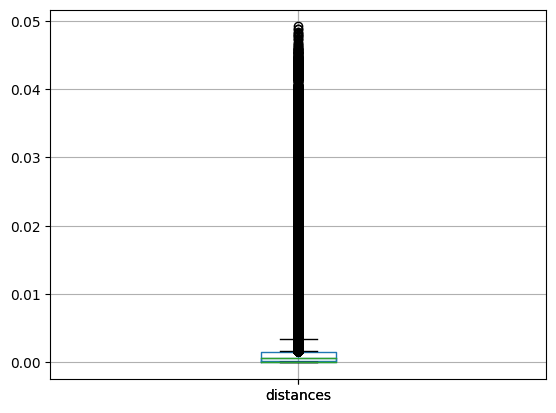

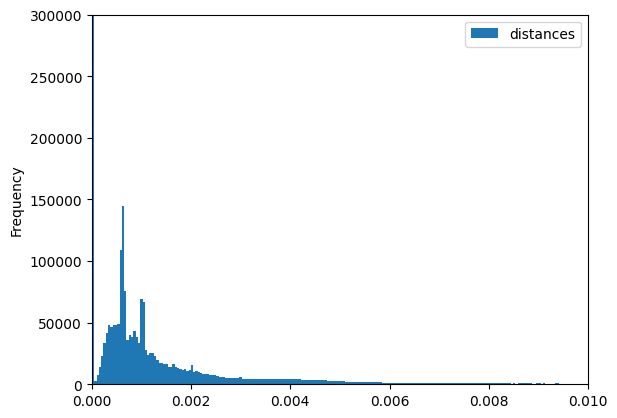

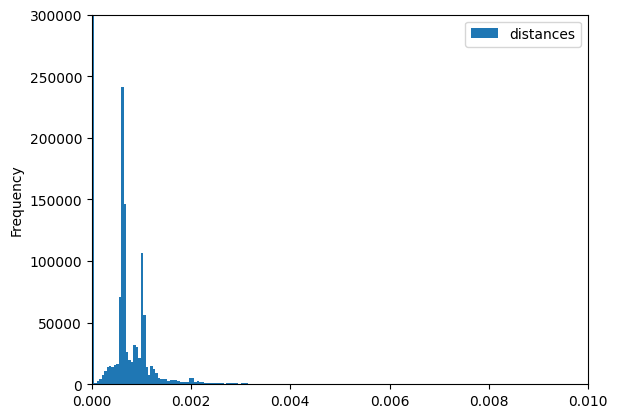

In [103]:

# Some graphs
ax1 = df.boxplot(return_type="axes") # BOXPLOT
ax2 = df_calibrated.boxplot(return_type="axes") # BOXPLOT
ax3 = df.plot(kind="hist", alpha=1, bins = 1000, xlim=(0, 0.01), ylim=(0, 0.3e6)) # HISTOGRAM
ax4 = df_calibrated.plot(kind="hist", alpha=1, bins = 1000, xlim=(0, 0.01), ylim=(0, 0.3e6)) # HISTOGRAM
plt.show()